<a href="https://colab.research.google.com/github/bharaniakella/Akellian_DL/blob/main/ann_batch_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [35]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

<ipython-input-35-6f5cb70bcde3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


In [36]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

In [37]:
train_data,test_data,train_labels,test_labels=train_test_split(dataT,labels,test_size=0.2)
train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)

train_loader=DataLoader(train_data,batch_size=32,shuffle=True,drop_last=True)
test_loader=DataLoader(train_data,batch_size=test_data.tensors[0].shape[0])

In [38]:
class Ann_BatchNorm(nn.Module):
  def __init__(self):
    super().__init__()

    self.input=nn.Linear(11,16)

    self.fc1=nn.Linear(16,32)
    self.bnorm1=nn.BatchNorm1d(16)
    self.fc2=nn.Linear(32,20)
    self.bnorm2=nn.BatchNorm1d(32)

    self.output=nn.Linear(20,1)

  def forward(self,x,doBN):

    x=F.relu(self.input(x))

    if doBN:

      x=self.bnorm1(x)
      x=F.relu(self.fc1(x))

      x=self.bnorm2(x)
      x=F.relu(self.fc2(x))

    else:
      x=F.relu(self.fc1(x))
      x=F.relu(self.fc2(x))

    return self.output(x)

In [39]:
num_epochs=500
def train_model(doBN=True):
  train_acc=[]
  test_acc=[]
  losses=torch.zeros(num_epochs)
  loss_fun=nn.BCEWithLogitsLoss()
  optimizer=torch.optim.SGD(wine_net.parameters(),lr=0.05)

  for epochi in range(num_epochs):
    wine_net.train()

    batch_acc=[]
    batch_loss=[]

    for x,y in train_loader:
      yhat=wine_net(x,doBN)
      loss=loss_fun(yhat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batch_loss.append(loss.item())
      batch_acc.append(100*torch.mean(((yhat>0)==y).float()).item())

    train_acc.append(np.mean(batch_acc))
    losses[epochi]=np.mean(batch_loss)

  wine_net.eval()
  x,y=next(iter(test_loader))
  yhat=wine_net(x,doBN)
  test_acc.append(100*torch.mean(((yhat>0)==y).float()).item())

  return train_acc, test_acc, losses

In [40]:
wine_net=Ann_BatchNorm()
train_acc, test_acc, losses=train_model(False)

In [41]:
wine_net=Ann_BatchNorm()
train_acc_yes, test_acc_yes, losses_yes=train_model(False)

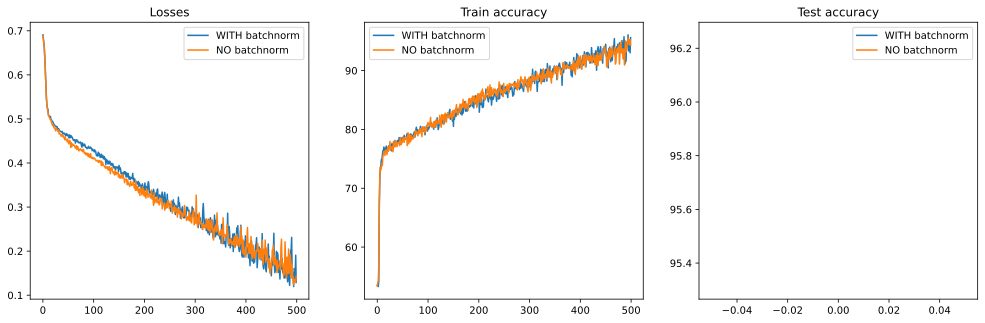

In [42]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(losses_yes,label='WITH batchnorm')
ax[0].plot(losses,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(train_acc_yes,label='WITH batchnorm')
ax[1].plot(train_acc,label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(test_acc_yes,label='WITH batchnorm')
ax[2].plot(test_acc,label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()